# 딥러닝의 기본 이미지 분류하기
## Chapter 2 CIFAR10 이미지 분류와 VGG, ResNet

In [ ]:
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np

import matplotlib.pyplot as plt

is_cuda = torch.cuda.is_available()   # GPU가 사용가능한지
device = torch.device("cuda" if is_cuda else "cpu") # GPU가 사용가능하다면 GPU를 사용 아니면 CPU 사용
print(is_cuda, device)

seed = 1010
random.seed(seed)         # python seed
np.random.seed(seed)      # numpy seed
torch.manual_seed(seed)   # torch seed
if device == 'cuda':
  torch.cuda.manual_seed_all(seed)  # gpu seed

### 2.1 CIFAR10 데이터셋

In [2]:
from torchvision import datasets

trainset = datasets.CIFAR10('CIFAR', train=True, download=True)
testset = datasets.CIFAR10('CIFAR', train=False, download=True)

100.0%


In [3]:
import pandas as pd
df = pd.DataFrame(trainset.targets)
df_count = df.groupby(0)[0].count()
print(df_count)

df = pd.DataFrame(testset.targets)
df_count = df.groupby(0)[0].count()
print(df_count)

0
0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
Name: 0, dtype: int64
0
0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
7    1000
8    1000
9    1000
Name: 0, dtype: int64


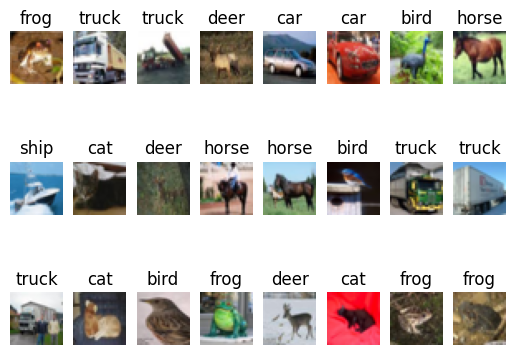

In [4]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

for i in range(24):
  plt.subplot(3,8,i+1)
  img, label = trainset[i]

  plt.gca().set_title(classes[label])
  plt.imshow(img)
  plt.axis('off')
plt.show()

## 학습

In [7]:
from torch.utils.data import random_split


def get_cifar_datasets(val=0.2, root_dir='CIFAR/'):
  # transform
  transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
  ])

  # split
  train_origin = datasets.CIFAR10(
      root=root_dir,
      train=True,
      download=True,
      transform=transform,
  )
  val_samples = int(len(train_origin) * val)
  train_samples = len(train_origin) - val_samples

  # dataset
  trainset, valset = random_split(
      train_origin,
       (train_samples, val_samples),
  )
  testset = datasets.CIFAR10(
      root=root_dir,
      train=False,
      download=True,
      transform=transform,
  )
  return trainset, valset, testset

dataset_list = get_cifar_datasets()

Files already downloaded and verified
Files already downloaded and verified


In [8]:
def train(model, dataloader, criterion, optimizer, epoch, device):
  # train mode
  model.train()

  # 학습 통계
  running_loss = 0
  correct = 0

  for i, (data, targets) in enumerate(dataloader):
    data, targets = data.to(device), targets.to(device)

    optimizer.zero_grad()
    outputs = model(data)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    # Accuracy 계산
    with torch.no_grad():
      _, predicted = torch.max(outputs, 1)
      correct += predicted.eq(targets.view_as(predicted)).sum()

  # Accuracy 출력
  data_num = len(dataloader.dataset)
  acc = 100. * correct / data_num
  print(
      f"[{epoch}/{EPOCH}]",
      f"train loss: {running_loss/len(dataloader):.4f}",
      f"train acc: {correct}/{data_num} ({acc:.2f}%)"
  )

  return running_loss/len(dataloader)

In [9]:
def validation(model, dataloader, criterion, epoch, device):
  # eval 모드
  model.eval()

  # 검증 통계
  correct = 0
  running_loss = 0.

  with torch.no_grad():   # gradient 계산 안하기
    for i, (data, targets) in enumerate(dataloader):
      data, targets = data.to(device), targets.to(device)   # data device로 이동

      outputs = model(data)               # forward
      loss = criterion(outputs, targets)  # loss 계산

      running_loss += loss.item()

      # Accuracy 계산
      _, predicted = torch.max(outputs, 1)
      correct += predicted.eq(targets.view_as(predicted)).sum()

  # Accuracy 계산
  data_num = len(dataloader.dataset)
  acc = 100. * correct / data_num
  print(f'[{epoch}/{EPOCH}] valid loss: {running_loss/len(dataloader):.4f} valid acc: {correct}/{data_num} ({acc:.2f}%)\n')

  return running_loss/len(dataloader)

In [10]:
def test(model, dataloader, device):
  # eval 모드
  model.eval()

  # 테스트 통계
  correct = 0

  with torch.no_grad():
    for data, targets in dataloader:
      data, targets = data.to(device), targets.to(device)

      outputs = model(data)    # forward

      # Accuracy 계산
      _, predicted = torch.max(outputs, 1)
      correct += predicted.eq(targets.view_as(predicted)).sum()

  # Accuracy 계산
  data_num = len(dataloader.dataset)
  print(f'Test Accuracy: {correct}/{data_num} ({100. * correct / data_num:.2f}%)')

## 모델

In [11]:
!pip install -q torchsummary

### VGG

In [12]:
import math
from collections import OrderedDict


class VGG(nn.Module):
  def __init__(self, model, num_classes):
    super(VGG, self).__init__()
    VGG_types = {
        'VGG16' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M',
                   512, 512, 512, 'M', 512, 512, 512, 'M'],
    }

    self.model = model
    self.feature_extractor = self.create_feature_extractor(VGG_types[model])

    self.fc = nn.Sequential(OrderedDict([
            ('dropout1', nn.Dropout()),
            ('fc1', nn.Linear(512, 512)),
            ('relu1', nn.ReLU(True)),
            ('dropout1', nn.Dropout()),
            ('fc2', nn.Linear(512, 512)),
            ('relu2', nn.ReLU(True)),
            ('fc2', nn.Linear(512, num_classes)),
        ]))

  def create_feature_extractor(self, layers, in_channels=3):
    feature_extractor = []

    for layer in layers:
      if type(layer) == int:
        out_channels = layer

        feature_extractor += [
          nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
          nn.BatchNorm2d(layer),
          nn.ReLU()
        ]
        in_channels = layer
      elif layer == 'M':
        feature_extractor += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]

    return nn.Sequential(*feature_extractor)

  def forward(self, x):
    x = self.feature_extractor(x)
    x = torch.flatten(x, start_dim=1)
    x = self.fc(x)
    return x

In [13]:
from torchsummary import summary
summary(VGG('VGG16', 10).to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [14]:
# Hyperparameters
# Training
EPOCH = 50
BATCH_SIZE = 32
NUM_WORKERS = 1
LR = 0.0001 # 1e-4

# Model
model = VGG('VGG16', num_classes=10).to(device)

# CIFAR dataloader
trainset, valset, testset = get_cifar_datasets(val=0.2)

# dataloader
train_loader = DataLoader(
    dataset=trainset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)
val_loader = DataLoader(
    dataset=valset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)
test_loader = DataLoader(
    dataset=testset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

# Loss, Optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_losses = []
val_losses = []

for epoch in range(1, EPOCH+1):
  tloss = train(model, train_loader, criterion, optimizer, epoch, device)
  vloss = validation(model, val_loader, criterion, epoch, device)

  train_losses.append(tloss)
  val_losses.append(vloss)

test(model, test_loader, device)

Files already downloaded and verified
Files already downloaded and verified
[1/50] train loss: 1.5548 train acc: 18358/40000 (45.90%)
[1/50] valid loss: 1.0449 valid acc: 6384/10000 (63.84%)

[2/50] train loss: 0.9399 train acc: 27159/40000 (67.90%)
[2/50] valid loss: 0.8968 valid acc: 7013/10000 (70.13%)

[3/50] train loss: 0.7328 train acc: 30112/40000 (75.28%)
[3/50] valid loss: 0.7077 valid acc: 7619/10000 (76.19%)

[4/50] train loss: 0.6154 train acc: 31766/40000 (79.42%)
[4/50] valid loss: 0.6006 valid acc: 7931/10000 (79.31%)

[5/50] train loss: 0.5300 train acc: 32984/40000 (82.46%)
[5/50] valid loss: 0.5475 valid acc: 8127/10000 (81.27%)

[6/50] train loss: 0.4582 train acc: 33916/40000 (84.79%)
[6/50] valid loss: 0.5415 valid acc: 8184/10000 (81.84%)

[7/50] train loss: 0.4058 train acc: 34564/40000 (86.41%)
[7/50] valid loss: 0.5604 valid acc: 8153/10000 (81.53%)

[8/50] train loss: 0.3565 train acc: 35266/40000 (88.17%)
[8/50] valid loss: 0.5057 valid acc: 8290/10000 (82.90

KeyboardInterrupt: ignored

## ResNet

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
summary(ResNet18().to(device), (3, 32, 32))

In [ ]:
# Hyperparameters
# Training
EPOCH = 50
BATCH_SIZE = 32
NUM_WORKERS = 1
LR = 0.0001 # 1e-4

# Model
model = ResNet18().to(device)

# CIFAR dataloader
trainset, valset, testset = get_cifar_datasets(val=0.2)

# dataloader
train_loader = DataLoader(
    dataset=trainset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)
val_loader = DataLoader(
    dataset=valset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)
test_loader = DataLoader(
    dataset=testset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

# Loss, Optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_losses = []
val_losses = []

for epoch in range(1, EPOCH+1):
  tloss = train(model, train_loader, criterion, optimizer, epoch, device)
  vloss = validation(model, val_loader, criterion, epoch, device)

  train_losses.append(tloss)
  val_losses.append(vloss)

test(model, test_loader, device)

Files already downloaded and verified
Files already downloaded and verified
[1/50] train loss: 1.2866 train acc: 21314/40000 (53.28%)
[1/50] valid loss: 0.9465 valid acc: 6567/10000 (65.67%)

[2/50] train loss: 0.8299 train acc: 28319/40000 (70.80%)
[2/50] valid loss: 0.8648 valid acc: 6959/10000 (69.59%)

[3/50] train loss: 0.6396 train acc: 31108/40000 (77.77%)
[3/50] valid loss: 0.6826 valid acc: 7537/10000 (75.37%)

[4/50] train loss: 0.5256 train acc: 32672/40000 (81.68%)
[4/50] valid loss: 0.6240 valid acc: 7855/10000 (78.55%)

[5/50] train loss: 0.4342 train acc: 34038/40000 (85.10%)
[5/50] valid loss: 0.5836 valid acc: 8011/10000 (80.11%)

[6/50] train loss: 0.3693 train acc: 34957/40000 (87.39%)
[6/50] valid loss: 0.5526 valid acc: 8081/10000 (80.81%)

[7/50] train loss: 0.3086 train acc: 35728/40000 (89.32%)
[7/50] valid loss: 0.5243 valid acc: 8250/10000 (82.50%)

[8/50] train loss: 0.2555 train acc: 36527/40000 (91.32%)
[8/50] valid loss: 0.5142 valid acc: 8306/10000 (83.06